# Deep Delta Hedging: Reinforcement learning applied to options hedging

### Importing dependencies


In [1]:
import logging 
import warnings
import os

In [2]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)
os.environ['KMP_AFFINITY'] = 'noverbose'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
from pathlib import Path
import sys

In [4]:
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

In [5]:
sys.path.append('Deep Hedging')

In [6]:
from DeepAgent import StochasticProcess, BlackScholes, HedgeAgent

### Generating asset paths

In [7]:
init = 100
drift = .007
diffusion = .2
T = 1/12
steps = 30
paths = 100000

In [8]:
stochastic_pro = StochasticProcess(steps, paths, T, drift, diffusion, init)

In [9]:
asset_paths = stochastic_pro.gen_process()

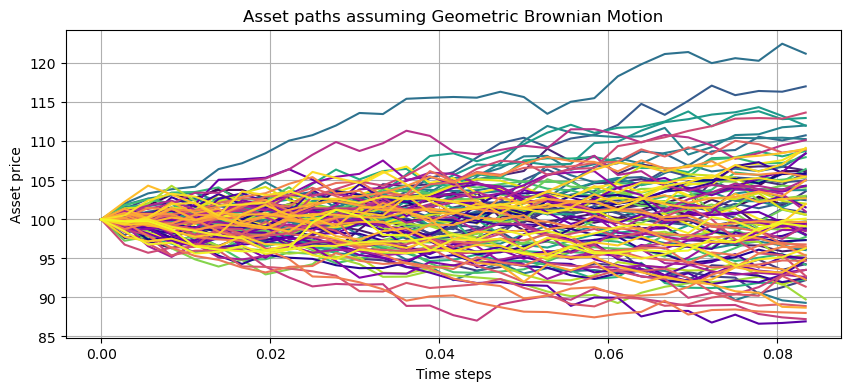

In [10]:
plt.figure(figsize = (10, 4))
plt.grid()
viridis = plt.cm.viridis(np.linspace(0, 1, asset_paths['raw'][: 100].shape[0] // 2))
plasma = plt.cm.plasma(np.linspace(0, 1, asset_paths['raw'][: 100].shape[0] // 2))
virisma = np.concatenate((viridis, plasma))

for path, color in zip(asset_paths['raw'][: 100], virisma):
    plt.plot(asset_paths['time'], path, color = color)
    
plt.title('Asset paths assuming Geometric Brownian Motion')
plt.xlabel('Time steps')
plt.ylabel('Asset price')
plt.show()

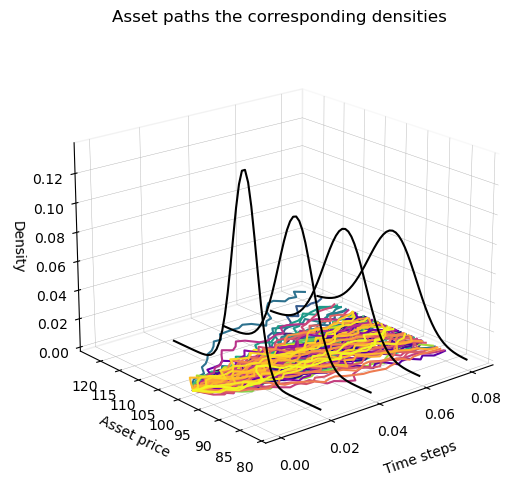

In [11]:
fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111, projection = '3d')
ax.view_init(20, -130)

ztime = np.zeros([len(asset_paths['time']), 1])
for i in range(100):
    X = asset_paths['time']
    Y = np.squeeze(np.transpose(asset_paths['raw'][i, :]))
    Z = np.squeeze(ztime)
    ax.plot(X, Y, Z, color = virisma[i])
    
T_ct = np.linspace(0, 1/12, 5)
Y = np.linspace(82, 118, 50)

for i in T_ct:
    X = np.full_like(Y, i)
    Z = stochastic_pro.density_fx(Y, i)
    ax.plot(X, Y, Z, 'k')

ax.xaxis._axinfo['grid']['linewidth'] = .3
ax.yaxis._axinfo['grid']['linewidth'] = .3
ax.zaxis._axinfo['grid']['linewidth'] = .3

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlabel('Time steps', labelpad = 10)
ax.set_ylabel('Asset price')
ax.set_zlabel('Density')
ax.set_title('Asset paths the corresponding densities')



plt.show()

### Setting

Let $I_k$, with values in $\mathbb{R}^r$, denote any new market information available at time $t_k$. Then $I := (I_k)_{k=0, \cdots, n}$ generates the filtration $\mathbb{F} = (\mathcal{F}_k)_{k=0, \cdots, n}$.\
Given a liability/contingent claim $Z$ at T, we use a set of $d$ hedging instruments denoted by the stochastic process $S$ such that
$$
S := S(t)_{t\geq0} := (S_t^1, \cdots, S_t^d)
$$
The Policy Gradient based agent looks for the optimal hedging strategy defined by
$$
\delta:= (\delta_k)_{k = 0, \cdots, n-1} := (\delta_k^1, \cdots, \delta_k^d)
$$
where $\delta$ is an $\mathbb{F-}$adapted stochastic process.\
$\delta_{k}$ denotes the agent’s holdings of the hedging assets between $t_{k}$ and $t_{k+1}$. The trader's portfolio value up to marturity varies by
$$
(\delta \cdot S)_T:= \sum_{k = 0}^{n - 1} \delta_k(S_{k+1} - S_k)
$$
To limit traing losses, the hedger must account for trading costs. Therefore, at time $t_k$ a trading action incurrs a cost $c_k(n)$ $\forall n \in \mathbb{R}^d$. The trading strategy $\delta$ up to $T$ has a total cost of
$$
C_T(\delta):= \sum_{k = 0}^{n}c_k(\delta_k - \delta_{k-1})
$$
With no additional cash is injected to the portfolio, the agent’s terminal portfolio value at maturity $T$ is given by
$$
\text{PnL}_T = - Z + (\delta . S)_T - C_T(\delta)
$$

### Reward function using a convex risk measure

The training will focus on optimality under a convex risk measure. Let $\mathcal{H}$ be the non-empty set of restricted trading strategies and $\mathcal{X}$ the set of asset positions, given the convex risk measure $\rho: Z \rightarrow \mathbb{R}$ for $Z \in \mathcal{X}$, the agent's optimal hedging strategy minimizes
$$
\inf_{\delta \in \mathcal{H}}\mathbb{E}\bigr[\rho \bigl(-Z + (\delta \cdot S)_T - C_T(\delta)\bigl)\bigr]
$$
A possibel metric that satisfies the is the properties of a convex risk measure is $\text{CVaR}_\alpha$ of confidence level $\alpha$. Therefore, the reward function ($\rho$) used will be the $\text{CVaR}$.

### Training and testing the reinforcement learning agent

In [12]:
batch_size = 3000
hedge = HedgeAgent(asset_paths['S'].shape[0], batch_size)

In [13]:
strike = 100
risk_aver = .5
epochs = 200
with tf.compat.v1.Session() as session:
    hedge.train(asset_paths['S'], np.ones(asset_paths['S'].shape[1]) * strike, risk_aver, epochs, session)

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 160
Epoch 170
Epoch 180
Epoch 190


In [85]:
paths_test = 48000
risk_aver_test = 0.99
np.random.seed(42)
stochastic_pro_test = StochasticProcess(steps, paths_test, T, drift, diffusion, init)

In [86]:
asset_paths_test = stochastic_pro_test.gen_process()

In [87]:
with tf.compat.v1.Session() as session:
    hedge.restore(session, 'run.ckpt')
    hedge_results = hedge.predict(asset_paths_test['S'], np.ones(asset_paths_test['S'].shape[1]) * strike,
                                 risk_aver_test, session)

### Comparing the reinforcement learning algorithm with the Black Scholes

In [88]:
black_scholes_p = BlackScholes('Call', init, strike, drift, diffusion, 0, T)
black_scholes_price = black_scholes_p.option_price()
black_scholes_time = np.zeros(asset_paths_test['S'].shape[0])
black_scholes_time[1:] = T / (asset_paths_test['S'].shape[0] - 1)
black_scholes_time = np.cumsum(black_scholes_time)
black_scholes_delta = np.zeros((asset_paths_test['S'].shape[0] - 1, asset_paths_test['S'].shape[1]))
for i in range(asset_paths_test['S'].shape[0] - 1):
    black_scholes_d = BlackScholes('Call', asset_paths_test['S'][i, :, 0], strike, drift,
                                   diffusion, black_scholes_time[i], T)
    black_scholes_delta[i, :] = black_scholes_d.option_delta()

In [89]:
def hedge_result(deltas, paths, strike, price, risk_aver):
    under_returns = paths[1:, :, 0] - paths[:-1, :, 0]
    hedge_ptf = np.sum(deltas * under_returns, axis = 0)
    payoff = np.maximum(paths[-1, :, 0] - strike, 0)
    pnl = - payoff + hedge_ptf + price
    mean_pnl = np.mean(pnl)
    CVaR_pnl = - np.mean(np.sort(pnl)[:int((1 - risk_aver) * pnl.shape[0])])
    return pnl, mean_pnl, CVaR_pnl

In [90]:
rl_pnl, rl_mean_pnl, rl_CVaR_pnl = hedge_result(hedge_results[2], asset_paths_test['S'],
                                                strike, black_scholes_price, risk_aver_test)
bs_pnl, bs_mean_pnl, bs_CVaR_pnl = hedge_result(black_scholes_delta, asset_paths_test['S'],
                                               strike, black_scholes_price, risk_aver_test)

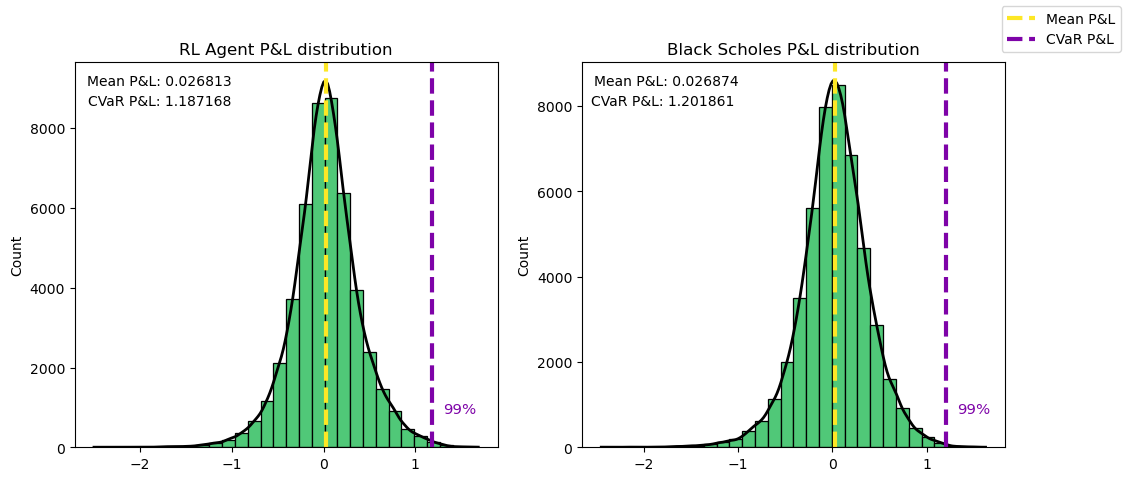

In [121]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

ax1 = sns.histplot(rl_pnl, ax = axes[0], kde = True, line_kws = {'lw': 2}, facecolor = '#50C878', edgecolor = 'k',
                  color = 'k', bins = 30)
ax2 = sns.histplot(bs_pnl, ax = axes[1], kde = True, line_kws = {'lw': 2}, facecolor = '#50C878', edgecolor = 'k',
                  color = 'k', bins = 30)

ax1.annotate(f'Mean P&L: {round(rl_mean_pnl, 6)}', xy = (.2, .95), xycoords = 'axes fraction', ha = 'center',
            va = 'center', fontsize = 10)
ax1.annotate(f'CVaR P&L: {round(rl_CVaR_pnl, 6)}', xy = (.2, .9), xycoords = 'axes fraction', ha = 'center',
            va = 'center', fontsize = 10)
ax1.annotate('99%', xy = (.91, .1), xycoords = 'axes fraction', ha = 'center', va = 'center', fontsize = 10.7, 
            color = '#7e03a8')

ax2.annotate(f'Mean P&L: {round(bs_mean_pnl, 6)}', xy = (.2, .95), xycoords = 'axes fraction', ha = 'center',
            va = 'center', fontsize = 10)
ax2.annotate(f'CVaR P&L: {round(bs_CVaR_pnl, 6)}', xy = (.19, .9), xycoords = 'axes fraction', ha = 'center',
            va = 'center', fontsize = 10)
ax2.annotate('99%', xy = (.926, .1), xycoords = 'axes fraction', ha = 'center', va = 'center', fontsize = 10.7, 
            color = '#7e03a8')


ax1.axvline(rl_mean_pnl, color = '#fde725', linestyle = '--', linewidth = 3)
ax1.axvline(rl_CVaR_pnl, color = '#7e03a8', linestyle = '--', linewidth = 3)
ax2.axvline(bs_mean_pnl, color = '#fde725', linestyle = '--', linewidth = 3)
ax2.axvline(bs_CVaR_pnl, color = '#7e03a8', linestyle = '--', linewidth = 3)

ax1.set_title('RL Agent P&L distribution')
ax2.set_title('Black Scholes P&L distribution')

legend = [Line2D([0], [0], color = '#fde725', linestyle = '--', linewidth = 3, label = 'Mean P&L'),
          Line2D([0], [0], color = '#7e03a8', linestyle = '--', linewidth = 3, label = 'CVaR P&L')]


fig.legend(handles = legend)



ax2.set_xticks([-2, -1, 0, 1])

plt.show()

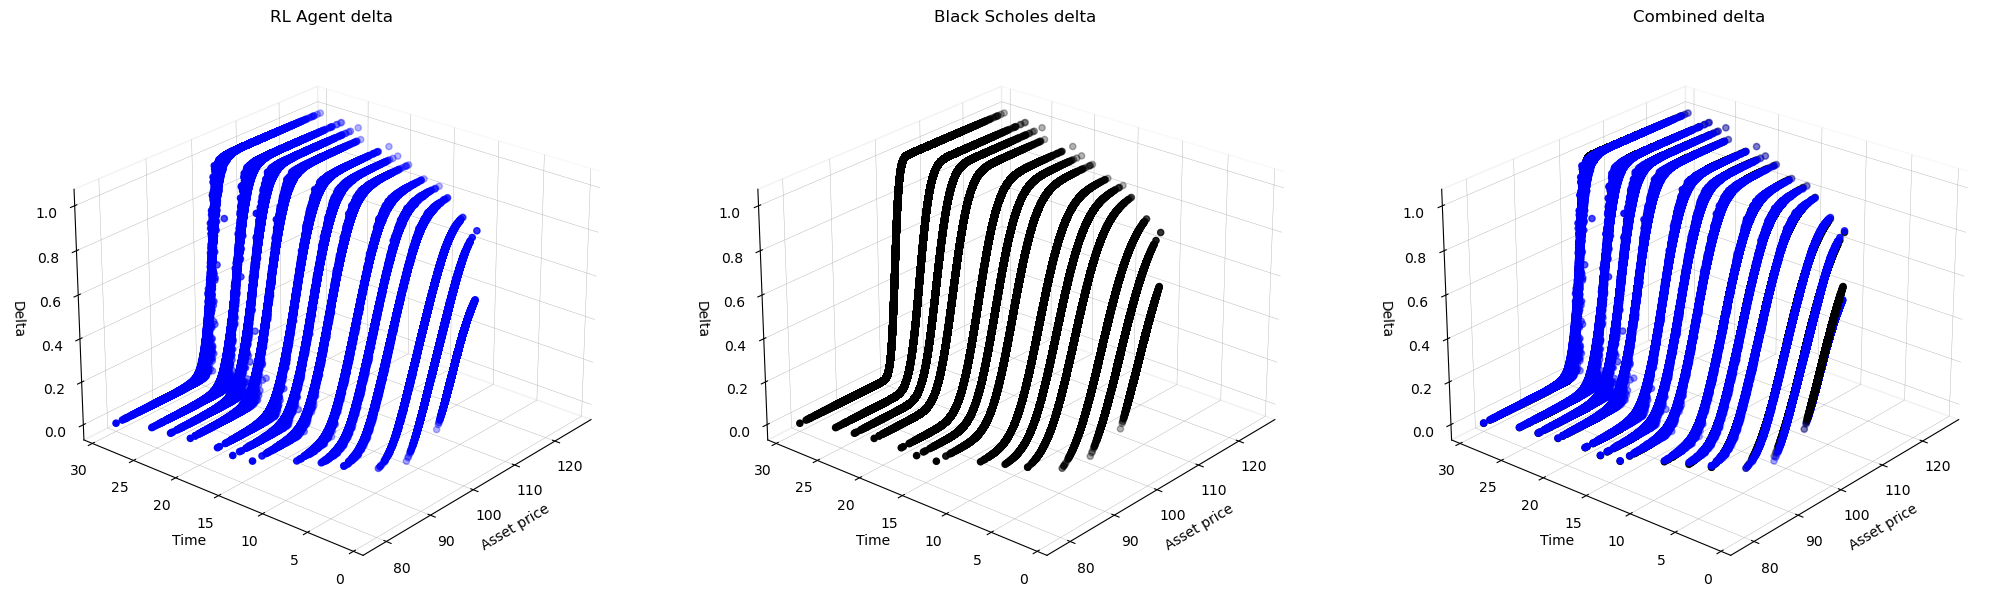

In [125]:
fig, axes = plt.subplots(1, 3, figsize = (25, 20), subplot_kw = {'projection': '3d'})

for ax, plot in zip(axes, ['RL Agent delta', 'Black Scholes delta', 'Combined delta']):
    ax.view_init(25, -140)
    for i in np.linspace(1, 29, 13, dtype = int):
        delta_paths = asset_paths_test['S'][i, :, 0]
        hedge1 = hedge_results[2][i, :]
        hedge2 = black_scholes_delta[i, :]
        
        if plot == 'RL Agent delta':
            ax.scatter(delta_paths, [i] * len(delta_paths), hedge1, color = 'blue')
        elif plot == 'Black Scholes delta':
            ax.scatter(delta_paths, [i] * len(delta_paths), hedge2, color='k')
        elif plot == 'Combined delta':
            ax.scatter(delta_paths, [i] * len(delta_paths), hedge1, color = 'blue')
            ax.scatter(delta_paths, [i] * len(delta_paths), hedge2, color = 'k')
            
    ax.set_xlabel('Asset price')
    ax.set_ylabel('Time')
    ax.set_zlabel('Delta')
    ax.set_title(plot)
    
    ax.xaxis._axinfo['grid']['linewidth'] = 0.3
    ax.yaxis._axinfo['grid']['linewidth'] = 0.3
    ax.zaxis._axinfo['grid']['linewidth'] = 0.3

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    

    
plt.show()

### Limitations

#### Sensitivity to changes in the strike price

In [188]:
with tf.compat.v1.Session() as session:
    hedge.restore(session, 'run.ckpt')
    hedge_results_moneyness = hedge.predict(asset_paths_test['S'],
                                            np.ones(asset_paths_test['S'].shape[1]) * (strike - 10),
                                            risk_aver_test, session)

In [189]:
black_scholes_p_moneyness = BlackScholes('Call', init, (strike - 10), drift, diffusion, 0, T)
black_scholes_price_moneyness = black_scholes_p_moneyness.option_price()
black_scholes_time_moneyness = np.zeros(asset_paths_test['S'].shape[0])
black_scholes_time_moneyness[1:] = T / (asset_paths_test['S'].shape[0] - 1)
black_scholes_time_moneyness = np.cumsum(black_scholes_time_moneyness)
black_scholes_delta_moneyness = np.zeros((asset_paths_test['S'].shape[0] - 1, asset_paths_test['S'].shape[1]))
for i in range(asset_paths_test['S'].shape[0] - 1):
    black_scholes_d_moneyness = BlackScholes('Call', asset_paths_test['S'][i, :, 0], (strike - 10), drift,
                                   diffusion, black_scholes_time[i], T)
    black_scholes_delta_moneyness[i, :] = black_scholes_d_moneyness.option_delta()

In [190]:
rl_pnl_moneyness, rl_mean_pnl_moneyness, rl_CVaR_pnl_moneyness = hedge_result(hedge_results_moneyness[2],
                                                                              asset_paths_test['S'],
                                                                              (strike - 10),
                                                                              black_scholes_price_moneyness,
                                                                              risk_aver_test)
bs_pnl_moneyness, bs_mean_pnl_moneyness, bs_CVaR_pnl_moneyness = hedge_result(black_scholes_delta_moneyness,
                                                                              asset_paths_test['S'],
                                                                              (strike - 10),
                                                                              black_scholes_price_moneyness,
                                                                              risk_aver_test)

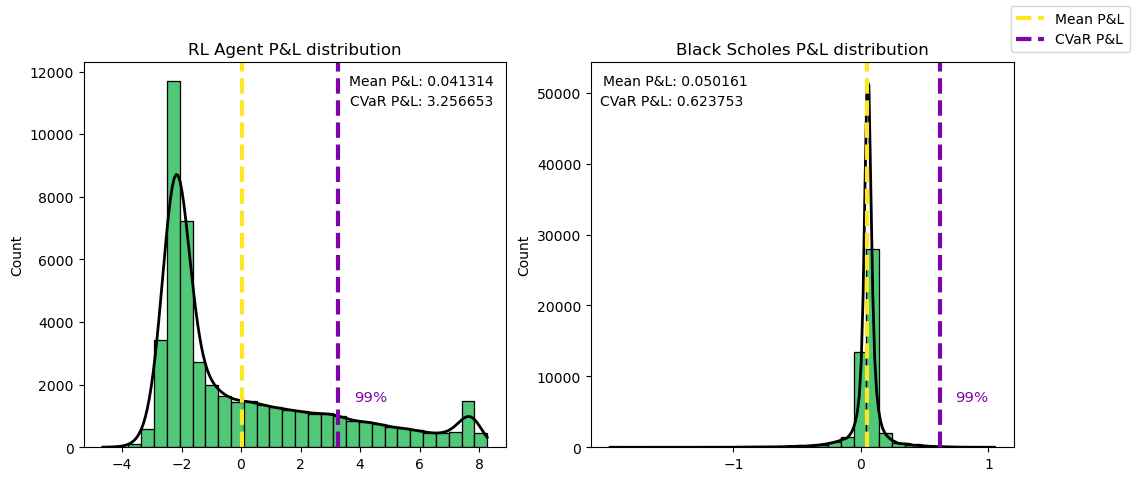

In [209]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

ax1 = sns.histplot(rl_pnl_moneyness, ax = axes[0], kde = True, line_kws = {'lw': 2}, facecolor = '#50C878', edgecolor = 'k',
                  color = 'k', bins = 30)
ax2 = sns.histplot(bs_pnl_moneyness, ax = axes[1], kde = True, line_kws = {'lw': 2}, facecolor = '#50C878', edgecolor = 'k',
                  color = 'k', bins = 30)
ax1.annotate(f'Mean P&L: {round(rl_mean_pnl_moneyness, 6)}', xy = (.8, .95), xycoords = 'axes fraction', ha = 'center',
            va = 'center', fontsize = 10)
ax1.annotate(f'CVaR P&L: {round(rl_CVaR_pnl_moneyness, 6)}', xy = (.8, .9), xycoords = 'axes fraction', ha = 'center',
            va = 'center', fontsize = 10)
ax1.annotate('99%', xy = (.68, .13), xycoords = 'axes fraction', ha = 'center', va = 'center', fontsize = 10.7, 
            color = '#7e03a8')

ax2.annotate(f'Mean P&L: {round(bs_mean_pnl_moneyness, 6)}', xy = (.2, .95), xycoords = 'axes fraction', ha = 'center',
            va = 'center', fontsize = 10)
ax2.annotate(f'CVaR P&L: {round(bs_CVaR_pnl_moneyness, 6)}', xy = (.19, .9), xycoords = 'axes fraction', ha = 'center',
            va = 'center', fontsize = 10)
ax2.annotate('99%', xy = (.9, .13), xycoords = 'axes fraction', ha = 'center', va = 'center', fontsize = 10.7, 
            color = '#7e03a8')


ax1.axvline(rl_mean_pnl_moneyness, color = '#fde725', linestyle = '--', linewidth = 3)
ax1.axvline(rl_CVaR_pnl_moneyness, color = '#7e03a8', linestyle = '--', linewidth = 3)
ax2.axvline(bs_mean_pnl_moneyness, color = '#fde725', linestyle = '--', linewidth = 3)
ax2.axvline(bs_CVaR_pnl_moneyness, color = '#7e03a8', linestyle = '--', linewidth = 3)

ax1.set_title('RL Agent P&L distribution')
ax2.set_title('Black Scholes P&L distribution')

legend = [Line2D([0], [0], color = '#fde725', linestyle = '--', linewidth = 3, label = 'Mean P&L'),
          Line2D([0], [0], color = '#7e03a8', linestyle = '--', linewidth = 3, label = 'CVaR P&L')]


fig.legend(handles = legend)

ax2.set_xticks([-1, 0, 1])


plt.show()

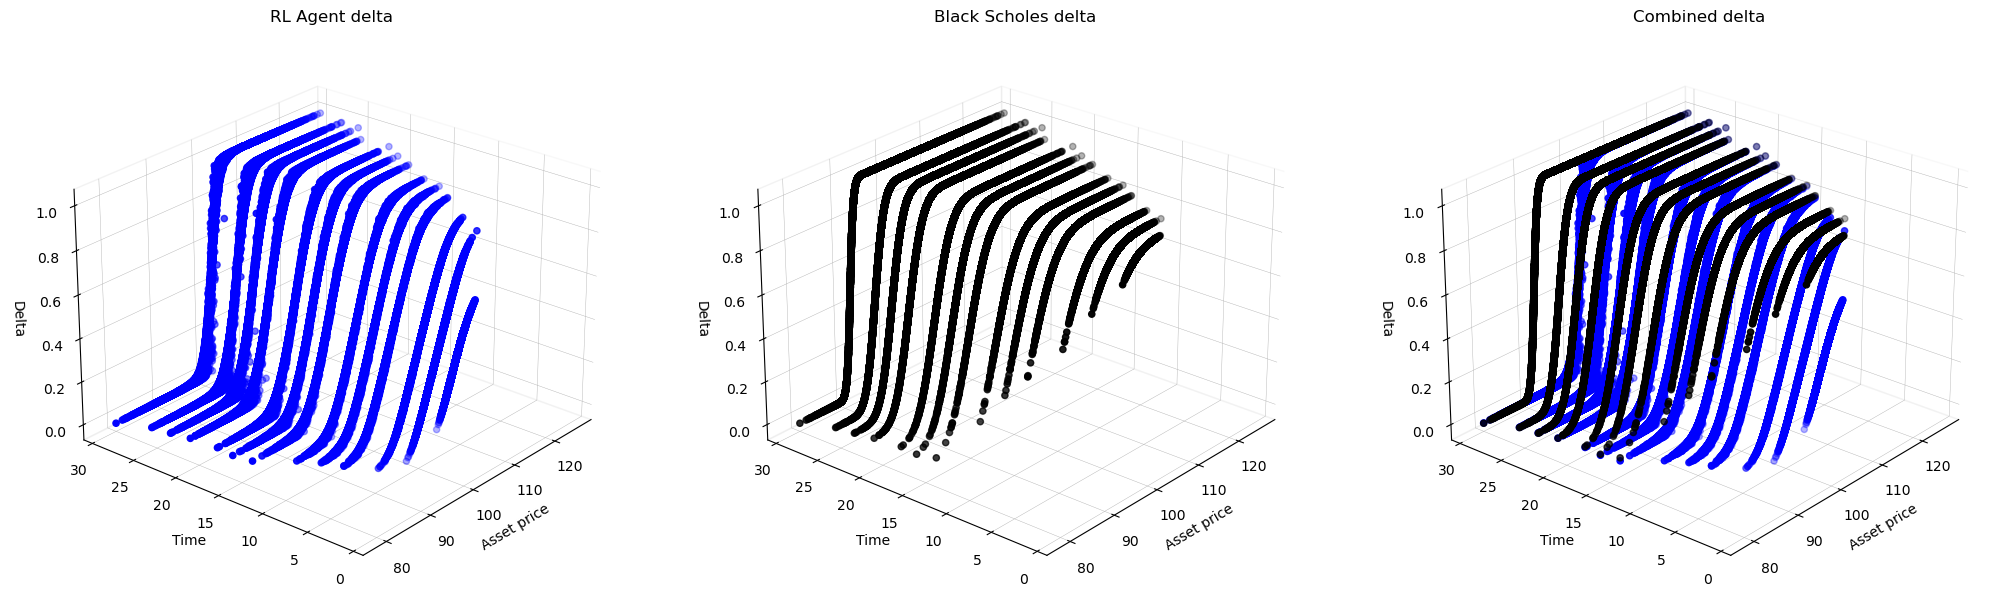

In [212]:
fig, axes = plt.subplots(1, 3, figsize = (25, 20), subplot_kw = {'projection': '3d'})

for ax, plot in zip(axes, ['RL Agent delta', 'Black Scholes delta', 'Combined delta']):
    ax.view_init(25, -140)
    for i in np.linspace(1, 29, 13, dtype = int):
        delta_paths = asset_paths_test['S'][i, :, 0]
        hedge1 = hedge_results_moneyness[2][i, :]
        hedge2 = black_scholes_delta_moneyness[i, :]
        
        if plot == 'RL Agent delta':
            ax.scatter(delta_paths, [i] * len(delta_paths), hedge1, color = 'blue')
        elif plot == 'Black Scholes delta':
            ax.scatter(delta_paths, [i] * len(delta_paths), hedge2, color='k')
        elif plot == 'Combined delta':
            ax.scatter(delta_paths, [i] * len(delta_paths), hedge1, color = 'blue')
            ax.scatter(delta_paths, [i] * len(delta_paths), hedge2, color = 'k')
            
    ax.set_xlabel('Asset price')
    ax.set_ylabel('Time')
    ax.set_zlabel('Delta')
    ax.set_title(plot)
    
    ax.xaxis._axinfo['grid']['linewidth'] = 0.3
    ax.yaxis._axinfo['grid']['linewidth'] = 0.3
    ax.zaxis._axinfo['grid']['linewidth'] = 0.3

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    

    
plt.show()